In [1]:
import pandas as pd
import numpy as np
import feather
import os
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

dataset = dataset = input()
path = os.getcwd() +'/Datasets/'+dataset+'/'

banks


In [2]:
df = pd.read_feather(path+dataset+'_clean.ftr')

In [3]:
df.shape

(4018801, 19)

## 1) Create a users dataframe

In [4]:
# For the purposes of summing up the tweets:
df['sum_tweets'] = 1

In [5]:
# Group by username:
df_users = df.groupby(['username',
                       'description',
                       'name',
                       'user_created_at']).agg({'public_metrics.retweet_count':'sum',
                                                               'public_metrics.like_count':'sum',
                                                               'verified':'mean',
                                                               'sum_pubmetrics':'sum',
                                                               'public_metrics.followers_count':'mean',
                                                               'public_metrics.following_count':'mean',
                                                               'public_metrics.tweet_count':'mean',
                                                               'sentiment':'sum',
                                                               'fintech':'sum',
                                                               'sum_tweets':'sum'}).reset_index()

# Some usernames have different descriptions due to data being gathered at different
#points in time and the users have changed their description in-between
# Drop the duplicates of some usernames:
df_users = df_users.drop_duplicates(subset='username',keep='first')

# Convert some columns to integer data type and verified to boolean
df_users['public_metrics.followers_count'] = df_users['public_metrics.followers_count'].astype('int32')
df_users['public_metrics.following_count'] = df_users['public_metrics.following_count'].astype('int32')
df_users['public_metrics.tweet_count'] = df_users['public_metrics.tweet_count'].astype('int32')
df_users['verified'] = df_users['verified'].astype('bool')

# Calculate the avg sentiment and avg impressions (likes+retweets) of the user's tweets:
df_users['avg_sentiment'] = df_users['sentiment']/df_users['sum_tweets']
df_users['avg_pubmetrics'] = df_users['sum_pubmetrics']/df_users['sum_tweets']

# Calculate the percentage of fintech tweets:
df_users['pct_fintech'] = df_users['fintech']/df_users['sum_tweets']

In [6]:
df_users.shape

(428895, 17)

In [7]:
df_users = df_users.reset_index(drop=True)

In [8]:
print('Number of users tweeting about fintech and banking:',df_users[df_users.fintech>0].shape[0])
print('Number of users tweeting only about banking:',df_users[df_users.fintech==0].shape[0])

Number of users tweeting about fintech and banking: 35792
Number of users tweeting only about banking: 393103


In [9]:
df_users.to_csv(path+dataset+'_users.csv')
df_users.to_feather(path+dataset+'_users.ftr')

In [ ]:
#df_users.to_csv(path+dataset+'_users18.csv')
#df_users.to_feather(path+dataset+'_users18.ftr')

## 2) Network analysis

### 2.1) Network Analysis Example

In [10]:
# A made up dataset for illustration purposes
df_test = pd.DataFrame(np.array([["neirajones", "zelfco"],
                                ["TweakMind", "convey"],
                                ["zelfco", "TweakMind"],
                                ["TweakMind", "zelfco"],
                                ["FinMe", ''],
                                ['BankMe', ''],
                                ['Zoomy', 'BlockCH'],
                                ['Zoomy', 'BlockCH']]),
                      columns=['username', 'mention'])
df_test

,username,mention
0,neirajones,zelfco
1,TweakMind,convey
2,zelfco,TweakMind
3,TweakMind,zelfco
4,FinMe,
5,BankMe,
6,Zoomy,BlockCH
7,Zoomy,BlockCH


In [11]:
G = nx.from_pandas_edgelist(df_test, 
                            source='username', 
                            target='mention',
                            create_using=nx.DiGraph())

G.remove_node('')
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 8\nNumber of edges: 5\nAverage in degree:   0.6250\nAverage out degree:   0.6250'

The number of nodes represents the number of distinct users. If a user such as *Zoomy* for example mentions *BlockCH* 2 times, then it will still count as 2 distinct users or nodes (*Zoomy* and *BlockCH*). 

The number of edges essentially represents the number of connections between users. The connection can be both ways, such as between *zelfco* and *TweakMind* or it can be one way cush as between *neirajones* and *zelfco*.

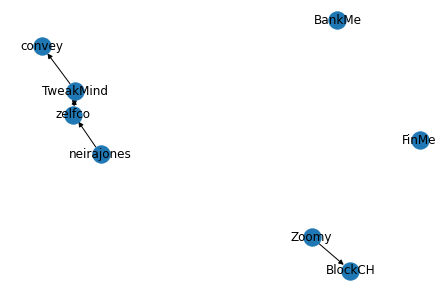

In [12]:
nx.draw(G, with_labels=True)
plt.show()

### 2.2) Data preparation for Network Analysis

In [13]:
df = pd.read_feather(path+dataset+'_full.ftr')

df = df[df['tweet_created_at']>=np.datetime64('2015-01-01')]
#df = df[df['tweet_created_at']>=np.datetime64('2018-01-01')]
#df = df[(df['tweet_created_at']>=np.datetime64('2012-01-01')) & (df['tweet_created_at']<np.datetime64('2015-01-01'))]
#df = df[(df['tweet_created_at']>=np.datetime64('2015-01-01')) & (df['tweet_created_at']<np.datetime64('2018-01-01'))]

# Set username as index so it is easier to play around with it
df = df.set_index('username')
# Select only the column that contains the tweet
df_text = df.iloc[:,[1]]
print('Dataframe shape:', df.shape)
print('Text dataframe shape:', df_text.shape)

Dataframe shape: (2837443, 16)
Text dataframe shape: (2837443, 1)


In [14]:
# Regular expression for saving everything after the @ symbol
mentions = re.compile(r'@[A-Za-z0-9]+')

def extract_mentions(text):
    """
    This function only saves the mentioned username
    and deletes everything else
    """
    text = ', '.join(mentions.findall(text))
    text = re.sub(r'@','',text)
    return text

df_text = df.text.apply(extract_mentions)
df_text = df_text.reset_index()

In [15]:
# This block deals with tweets that mention multiple users
# It is a very inefficient way, takes about a minute to run
uzrs = df_text.set_index('username')

# 1) Extract all the mentions and create a column for 1 mention each
for i in range(30):
    uzrs[f'mention{i}'] = uzrs['text'].str.split(', ').str[i]

# 2) Create a new dataframe
df_uzrs = uzrs['mention0'].copy()

# 3) Append all the columns with only 1 mention under the new dataframe
for i in range(1,30):
    df_uzrs = df_uzrs.append(uzrs[f'mention{i}'].dropna())
    
del uzrs

In [16]:
# Do some cleaning up:
df_uzrs = df_uzrs.to_frame()
df_uzrs = df_uzrs.reset_index()
df_uzrs = df_uzrs.rename(columns={0:'mention'})

In [17]:
date = input('Select date period (yy-yy): ')
df_uzrs.to_feather(path+dataset+'_networkX_'+date+'.ftr')

Select date period (yy-yy): 15-21


### 2.3) Performing Network Analysis on the whole dataset

In [ ]:
#df_uzrs = pd.read_feather(path+dataset+'_networkX18_21.ftr')

In [18]:
G = nx.Graph()

In [19]:
G = nx.from_pandas_edgelist(df_uzrs, 
                            source='username', 
                            target='mention',
                            edge_key='mention',
                            create_using=nx.DiGraph())

G.remove_node('')
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 436583\nNumber of edges: 664198\nAverage in degree:   1.5214\nAverage out degree:   1.5214'

In [20]:
from networkx import degree_centrality, in_degree_centrality
from networkx import out_degree_centrality

def centrality_measures(H, top):
    """
    This function prints out the centrality measures for
    how the Twitter users are connected to each other.
    H: a directed graph object
    top: how many users to print out
    """
    
    print(f'Top {top} in-degree centrality:')
    dic = in_degree_centrality(H)
    for k,v in sorted(dic.items(), 
                      key=lambda x: x[1], 
                      reverse = True)[:top]:
        print(k,'\t',round(v,4))
    print('')
    
    print(f'Top {top} out-degree centrality:')
    dic = out_degree_centrality(H)
    for k,v in sorted(dic.items(), 
                      key=lambda x: x[1], 
                      reverse = True)[:top]:
        print(k,'\t',round(v,4))
    print('')
    
    print(f'Top {top} degree centrality:')
    dic = degree_centrality(H)
    for k,v in sorted(dic.items(), 
                      key=lambda x: x[1], 
                      reverse = True)[:top]:
        print(k,'\t',round(v,4))

In [ ]:
centrality_measures(G, 20)

In [21]:
# Total number of users
df_uzrs.groupby('username').count().shape

(253259, 1)

## 3) Add all mentions to the main dataframe

In [22]:
df_uzrs['mentioned'] = 1
df_uzrs = df_uzrs.groupby(['mention']).sum().reset_index()

In [23]:
# Merge the dataframe with all the mentions to the main users dataframe
df_users = pd.merge(df_users,df_uzrs,how='left',left_on='username',right_on='mention')
del df_users['mention']
df_users['mentioned'] = df_users['mentioned'].fillna(0)

In [24]:
# CSV is for tableau
df_users.to_csv(path+dataset+'_users.csv')
df_users.to_feather(path+dataset+'_users.ftr')